- [acoustics](https://github.com/python-acoustics/python-acoustics) 필요 (pip install acoustics)

In [14]:
import os
import re
from glob import glob
from scipy.io import wavfile
from scipy import signal
import IPython.display as ipd

import numpy as np
import pandas as pd
from acoustics.generator import noise_generator, noise

import matplotlib.pyplot as plt
%matplotlib inline

TRAIN_PATH = './input/train/audio/'

# Noise Mixing

### 1. raw sound

In [2]:
file_path = os.path.join(TRAIN_PATH, 'yes/0a7c2a8d_nohash_0.wav')

In [3]:
sample_rate, samples = wavfile.read(file_path)

In [4]:
ipd.Audio(samples, rate=sample_rate)

In [18]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    '''
    Calculates Spectrogram.
    '''
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

# Note, that we are taking logarithm of spectrogram values. 
# It will make our plot much more clear, moreover, it is strictly connected to the way people hear. 
# We need to assure that there are no 0 values as input to logarithm.

In [19]:
def show_wave(samples, sample_rate, figsize=(20, 4)):
    fig = plt.figure(figsize=figsize)
    plt.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
    plt.title('Raw wave')
    plt.ylabel('Amplitude')
    plt.show()

In [20]:
def show_spectrogram(samples, sample_rate, figsize=(20, 4)):
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    fig = plt.figure(figsize=figsize)
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.title('Spectrogram')
    plt.ylabel('Freqs in Hz')
    plt.xlabel('Seconds')
    plt.show()

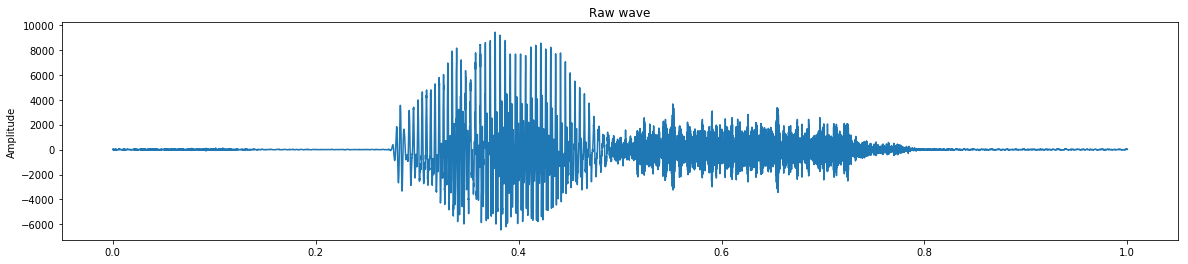

In [8]:
show_wave(samples, sample_rate)

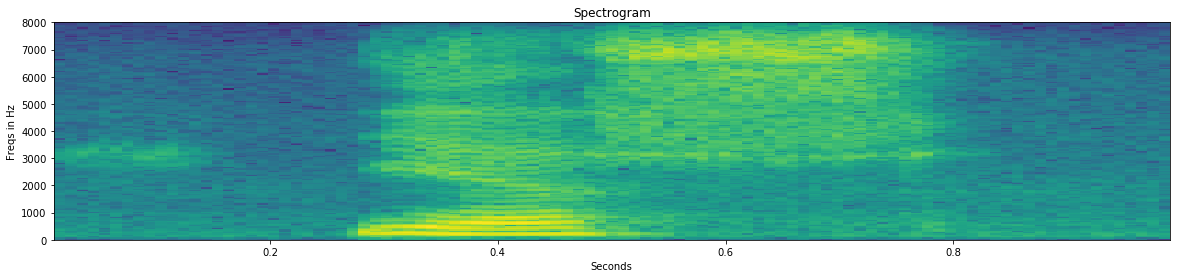

In [9]:
show_spectrogram(samples, sample_rate)

### 2. raw sound + noise

In [10]:
# white	+3 dB	0 dB
# pink	0 dB	-3 dB
# blue	+6 dB	+3 dB
# brown	-3 dB	-6 dB
# violet	+9 dB	+6 dB

In [11]:
# noise sound
sample_rate = 16000
noise_samples = noise(N=16000, color='white')
new_samples = noise_samples*(10**3)+samples

In [12]:
ipd.Audio(new_samples, rate=sample_rate)

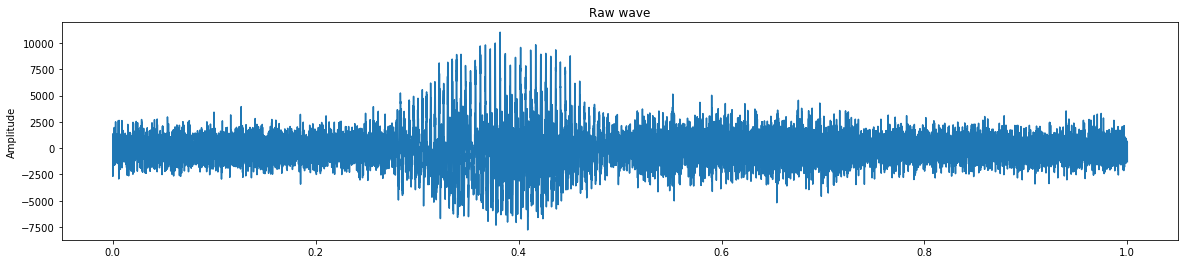

In [13]:
show_wave(new_samples, sample_rate)

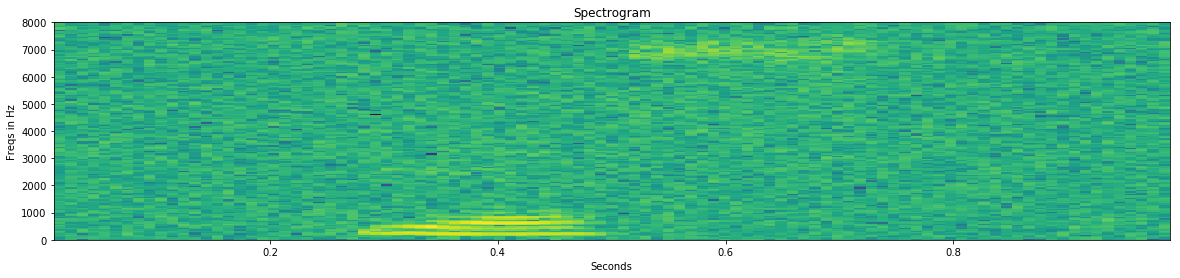

In [14]:
show_spectrogram(new_samples, sample_rate)

# Data Augmentation

In [23]:
def chop_audio(samples, L=16000, num=200):
    '''
    chop audios that are larger than 16000(eg. wav files in background noises folder) to 16000 in length.
    create several chunks out of one large wav files given the parameter 'num'.
    '''
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

In [10]:
def noise_mixing(samples, sample_rate, noise_color, noise_amp):
    noise_samples = noise(N=len(samples), color=noise_color)
    new_samples = noise_samples*noise_amp+samples
    return new_samples

In [11]:
## utility function to grab all wav files inside train data folder.
def list_wavs_fname(dirpath, ext='wav'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

In [21]:
labels, fnames = list_wavs_fname(TRAIN_PATH)

./input/train/audio/


In [31]:
%%time
## 각 폴더에 'nm_' 이 앞에붙어서 노이즈믹싱된 파일 생성
for label, fname in zip(labels, fnames):
    if label == '_background_noise_':
        sample_rate, samples = wavfile.read(os.path.join(TRAIN_PATH, label, fname))
        for i, chopped_samples in enumerate(chop_audio(samples, L=16000, num=200)):
            if np.random.random() > 0.5: # 0.5의 확률로 노이즈믹싱
                noise_amp = 5**abs(np.random.normal(0, 1.2))
                noise_color = np.random.choice(['white', 'pink', 'blue', 'brown', 'violet'])
                chopped_samples = noise_mixing(chopped_samples, sample_rate, noise_color, noise_amp)
            n_fname = 'nm_{}_{}'.format(i, fname)
            wavfile.write(os.path.join(TRAIN_PATH, label, n_fname), sample_rate, chopped_samples)
            
    else: # 나머지 일반 label 일때,
        if np.random.random() > 0.5: # 0.5의 확률로 노이즈믹싱
            sample_rate, samples = wavfile.read(os.path.join(TRAIN_PATH, label, fname))
            noise_amp = 5**abs(np.random.normal(0, 1.2))
            noise_color = np.random.choice(['white', 'pink', 'blue', 'brown', 'violet'])
            samples = noise_mixing(samples, sample_rate, noise_color, noise_amp)
            n_fname = 'nm_' + fname
            wavfile.write(os.path.join(TRAIN_PATH, label, n_fname), sample_rate, samples)

CPU times: user 57.7 s, sys: 2.54 s, total: 1min
Wall time: 1min


/home/chi/anaconda3/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [30]:
# 다시 원래대로 롤백하려면... ('nm_' 이 앞에 붙은 파일 제거)
fpaths = glob(os.path.join(TRAIN_PATH, r'*/nm_*' + 'wav'))
print(len(fpaths))
for fpath in fpaths:
    os.remove(fpath)

0
